In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import matplotlib.ticker as ticker

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Antibody Stripping/' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

## Look at the values separately

In [3]:
results={"expname":[],"day":[],"before vals":[],"after vals":[],"ratio":[],"ratio normed to day 0":[]}
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("before" in str(filelist[i]))==True:
        if ("New folder" in str(filelist[i]))==False:
            if ("perc" in str(filelist[i]))==False:
                if ("8day" in str(filelist[i]))==False:
                    if filelist[i].endswith(".txt"): 
                        print(filelist[i])
                        results["expname"].append(filelist[i].split('/')[-3])
                        results["day"].append(filelist[i].split('/')[-2])
                        
                        after='/'.join(filelist[i].split('/')[:-1])+'/after.txt'
                        before=filelist[i]
                        
                        lineList = [line.rstrip('\n') for line in open(before)]
                        lineListbefore=np.array([float(i) for i in lineList])
                        results["before vals"].append(lineListbefore)
                        
                        lineList = [line.rstrip('\n') for line in open(after)]
                        lineListafter=np.array([float(i) for i in lineList])
                        results["after vals"].append(np.array(lineListafter))
                        results["ratio"].append(lineListafter.mean()/lineListbefore.mean())
                        results["ratio normed to day 0"].append(lineListafter.mean()/lineListbefore.mean())

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Antibody Stripping/20180506_longterm/01_immediatelyafterstain/before.txt
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Antibody Stripping/20180506_longterm/02_1day/before.txt
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Antibody Stripping/20180506_longterm/03_2day/before.txt
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Antibody Stripping/20180506_longterm/04_3day/before.txt
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Antibody Stripping/20180506_longterm/05_4day/before.txt
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Antibody Stripping/20180506_longterm/06_5day/before.txt
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Antibody Stripping/20180506_longterm/07_6day/before.txt
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Antibody Stripping/20180506_longterm/08_7day/before.txt
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Antibody Stri

In [4]:
df_all=pd.DataFrame(results)

In [5]:
df_all["Day"]="0"
df_all.loc[df_all['day'].str.contains('immediately'), 'Day'] = '0'
df_all.loc[df_all['day'].str.contains('1day'), 'Day'] = '1'
df_all.loc[df_all['day'].str.contains('2day'), 'Day'] = '2'
df_all.loc[df_all['day'].str.contains('3day'), 'Day'] = '3'
df_all.loc[df_all['day'].str.contains('4day'), 'Day'] = '4'
df_all.loc[df_all['day'].str.contains('5day'), 'Day'] = '5'
df_all.loc[df_all['day'].str.contains('6day'), 'Day'] = '6'
df_all.loc[df_all['day'].str.contains('7day'), 'Day'] = '7'

In [6]:
for exp in df_all["expname"].unique():
    dfexp=df_all[df_all["expname"]==exp]
    zero_ratio=dfexp[dfexp["Day"]=="0"]["ratio"].values
    df_all.loc[df_all["expname"]==exp,"ratio normed to day 0"]/=zero_ratio

## Read only the final averages from csv file

In [7]:
df=pd.read_csv(expdir+'allexps_ratiobeforeoverafter_normedtofirstratio.csv',sep=';',header='infer')
lineList = [line.rstrip('\n') for line in open(before)]
lineList=[float(i) for i in lineList]

In [8]:
results={"exp number":[],"day":[],"ratio":[]}
for i in range(len(df)):
    for j in range(0,8):
        results["exp number"].append(i)
        results["day"].append(j)
        results["ratio"].append(df.loc[i][j])
df2=pd.DataFrame(results)

## Quick look

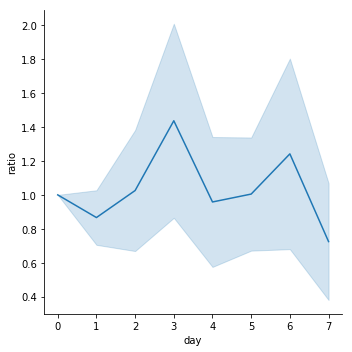

In [9]:
sns.relplot(x="day",y="ratio",data=df2, dashes=False, markers=True, kind="line",ci='sd')

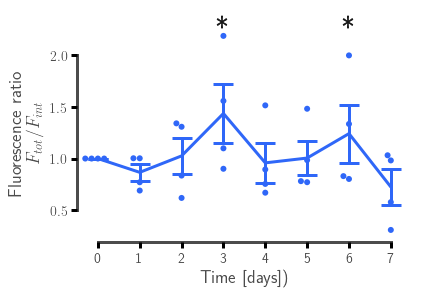

In [33]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.set_palette("Set2")

from matplotlib import rc

rc('text', usetex=True)
fig=plt.figure()
#d=sns.swarmplot(x="day",y="ratio",data=df2,hue="exp number")
g=sns.swarmplot(x="day",y="ratio",data=df2,color='#2F67F8',size=6)
g=sns.lineplot(x="day",y="ratio",data=df2,linewidth=3,color='#2F67F8',ci=None)
means=[]
sems=[]
for i in range(0,8):
    means.append(df2[df2["day"]==i]["ratio"].mean())
    sems.append(df2[df2["day"]==i]["ratio"].sem())
    

plt.errorbar(x=np.arange(0,8,1),y=means,yerr=sems,
            xerr=None,ecolor='#2F67F8',fmt='none',capsize=10,linewidth=3,capthick=3)

#plt.hlines(y=means[1],xmin=0.7,xmax=1.3)   

col='k'
y=2.2
h=0
x1,x2=2,4
pval=0.01
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=30, weight='bold')    
x1,x2=5,7
pval=0.01
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=30, weight='bold')    
    

plt.title('')
plt.locator_params(axis='y', nbins=5)
plt.yticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)
plt.xticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)



g.tick_params(width=3,color='black')
#g.set_ylabel('Fluorescence intensity (AU)',color='black',alpha=.7,labelpad=3,size=28,weight='bold')

g.set_xlabel('Time [days])',color='black',alpha=.7,fontsize=18,weight='bold')

g.set_ylabel(r"Fluorescence ratio"
           "\n"  # Newline: the backslash is interpreted as usual
           r"$F_{tot}/F_{int}$",
    color='black',alpha=.7,fontsize=18,weight='bold')

g.grid(False)

sns.despine(ax=g,right=True,top=True,trim=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'stripping.svg', bbox_inches='tight', format='svg')



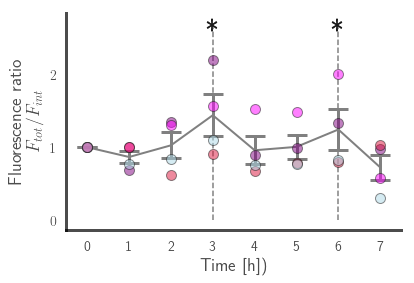

In [11]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("white")
sns.set_palette("Set2")

from matplotlib import rc

rc('text', usetex=True)
#color=iter(cm.rainbow(np.linspace(0,1,4)))
color=["purple","magenta","crimson","lightblue"]
#d=sns.swarmplot(x="day",y="ratio",data=df2,hue="exp number")
i=-1
for exp in df2["exp number"].unique():
    i+=1
    dfexp=df2[df2["exp number"]==exp]
    g=sns.swarmplot(x="day",y="ratio",data=dfexp,linewidth=1,color=color[i],size=10,alpha=.5,edgecolor='k')

g=sns.lineplot(x="day",y="ratio",data=df2,linewidth=2,color='grey',ci=None)
means=[]
sems=[]
for i in range(0,8):
    means.append(df2[df2["day"]==i]["ratio"].mean())
    sems.append(df2[df2["day"]==i]["ratio"].sem())
    

plt.errorbar(x=np.arange(0,8,1),y=means,yerr=sems,
            xerr=None,ecolor='grey',fmt='none',capsize=10,linewidth=3,capthick=3)

    

col='k'
y=2.5
h=0
x1,x2=2,4
pval=0.01
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=30, weight='bold')    
x1,x2=5,7
pval=0.01
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=30, weight='bold')    
    


plt.title('')
plt.locator_params(axis='y', nbins=5)
plt.yticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)
plt.xticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)

g.vlines(x=3,linestyles='--', label='',ymin=0,ymax=2.7,color='grey')
g.vlines(x=6,linestyles='--', label='',ymin=0,ymax=2.7,color='grey')



g.tick_params(width=3,color='black')
#g.set_ylabel('Fluorescence intensity (AU)',color='black',alpha=.7,labelpad=3,size=28,weight='bold')

g.set_xlabel('Time [h])',color='black',alpha=.7,fontsize=18,weight='bold')

g.set_ylabel(r"Fluorescence ratio"
           "\n"  # Newline: the backslash is interpreted as usual
           r"$F_{tot}/F_{int}$",
    color='black',alpha=.7,fontsize=18,weight='bold')

g.grid(False)

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)

## Stats

## Normal ttest

In [69]:
var="ratio"
day0=df2[df2["day"]==0][var].dropna()
day1=df2[df2["day"]==1][var].dropna()
day3=df2[df2["day"]==3][var].dropna()
day2=df2[df2["day"]==2][var].dropna()
day4=df2[df2["day"]==4][var].dropna()
day6=df2[df2["day"]==6][var].dropna()
day5=df2[df2["day"]==5][var].dropna()
day7=df2[df2["day"]==7][var].dropna()

#day1norm=day1/day0.mean()
day2norm21=day2/day1.mean()

#day3norm22=day3/day2.mean()

day3norm=day3/day2norm21.mean()
day4norm=day4/day3norm.mean()

In [70]:
[stat,pval]=stats.ttest_rel(day3norm.values, day2norm21.values)
print(pval)

0.7909895453015954


## ttest between normalized values (normalize to group undergoing test)

In [114]:
arrayexps=np.stack([df2[df2["exp number"]==0]["ratio"].values/df2[df2["exp number"]==0]["ratio"].values[3],
                   df2[df2["exp number"]==1]["ratio"].values/df2[df2["exp number"]==1]["ratio"].values[3],
                   df2[df2["exp number"]==2]["ratio"].values/df2[df2["exp number"]==2]["ratio"].values[3],
                   df2[df2["exp number"]==3]["ratio"].values/df2[df2["exp number"]==3]["ratio"].values[3]])

In [115]:
[stat,pval]=stats.ttest_rel(arrayexps[:,3], arrayexps[:,2])
print(pval)

0.010873325146167612


In [109]:
arrayexps=np.stack([df2[df2["exp number"]==0]["ratio"].values/df2[df2["exp number"]==0]["ratio"].values[6],
                   df2[df2["exp number"]==1]["ratio"].values/df2[df2["exp number"]==1]["ratio"].values[6],
                   df2[df2["exp number"]==2]["ratio"].values/df2[df2["exp number"]==2]["ratio"].values[6],
                   df2[df2["exp number"]==3]["ratio"].values/df2[df2["exp number"]==3]["ratio"].values[6]])

In [116]:
[stat,pval]=stats.ttest_rel(arrayexps[:,6], arrayexps[:,4])
print(pval)

0.03705642300701708
